In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [5]:
iris = pd.read_csv('data/iris.csv')

In [29]:
X = iris.drop(['Species', 'Id'], axis=1)  # Drop both Species and Id columns
y = iris['Species']

if isinstance(y.iloc[0], str):
    species_to_num = {species: i for i, species in enumerate(y.unique())}
    y_numeric = y.map(species_to_num)
else:
    y_numeric = y
    

# 2. Explore the dataset

In [30]:
print("\n2. Exploring the dataset")
print("Shape of the dataset:", X.shape)
print("Number of features:", X.shape[1])

print("\nFirst 5 rows of features:")
print(X.head())

print("\nClass distribution:")
print(y.value_counts())

print("\nSummary statistics:")
print(X.describe())

print("\nChecking for missing values:")
print(X.isnull().sum().sum())


2. Exploring the dataset
Shape of the dataset: (150, 4)
Number of features: 4

First 5 rows of features:
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5            1.4           0.2
1            4.9           3.0            1.4           0.2
2            4.7           3.2            1.3           0.2
3            4.6           3.1            1.5           0.2
4            5.0           3.6            1.4           0.2

Class distribution:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

Summary statistics:
       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count     150.000000    150.000000     150.000000    150.000000
mean        5.843333      3.054000       3.758667      1.198667
std         0.828066      0.433594       1.764420      0.763161
min         4.300000      2.000000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%     

# 3. Data visualization

<Figure size 1000x800 with 0 Axes>

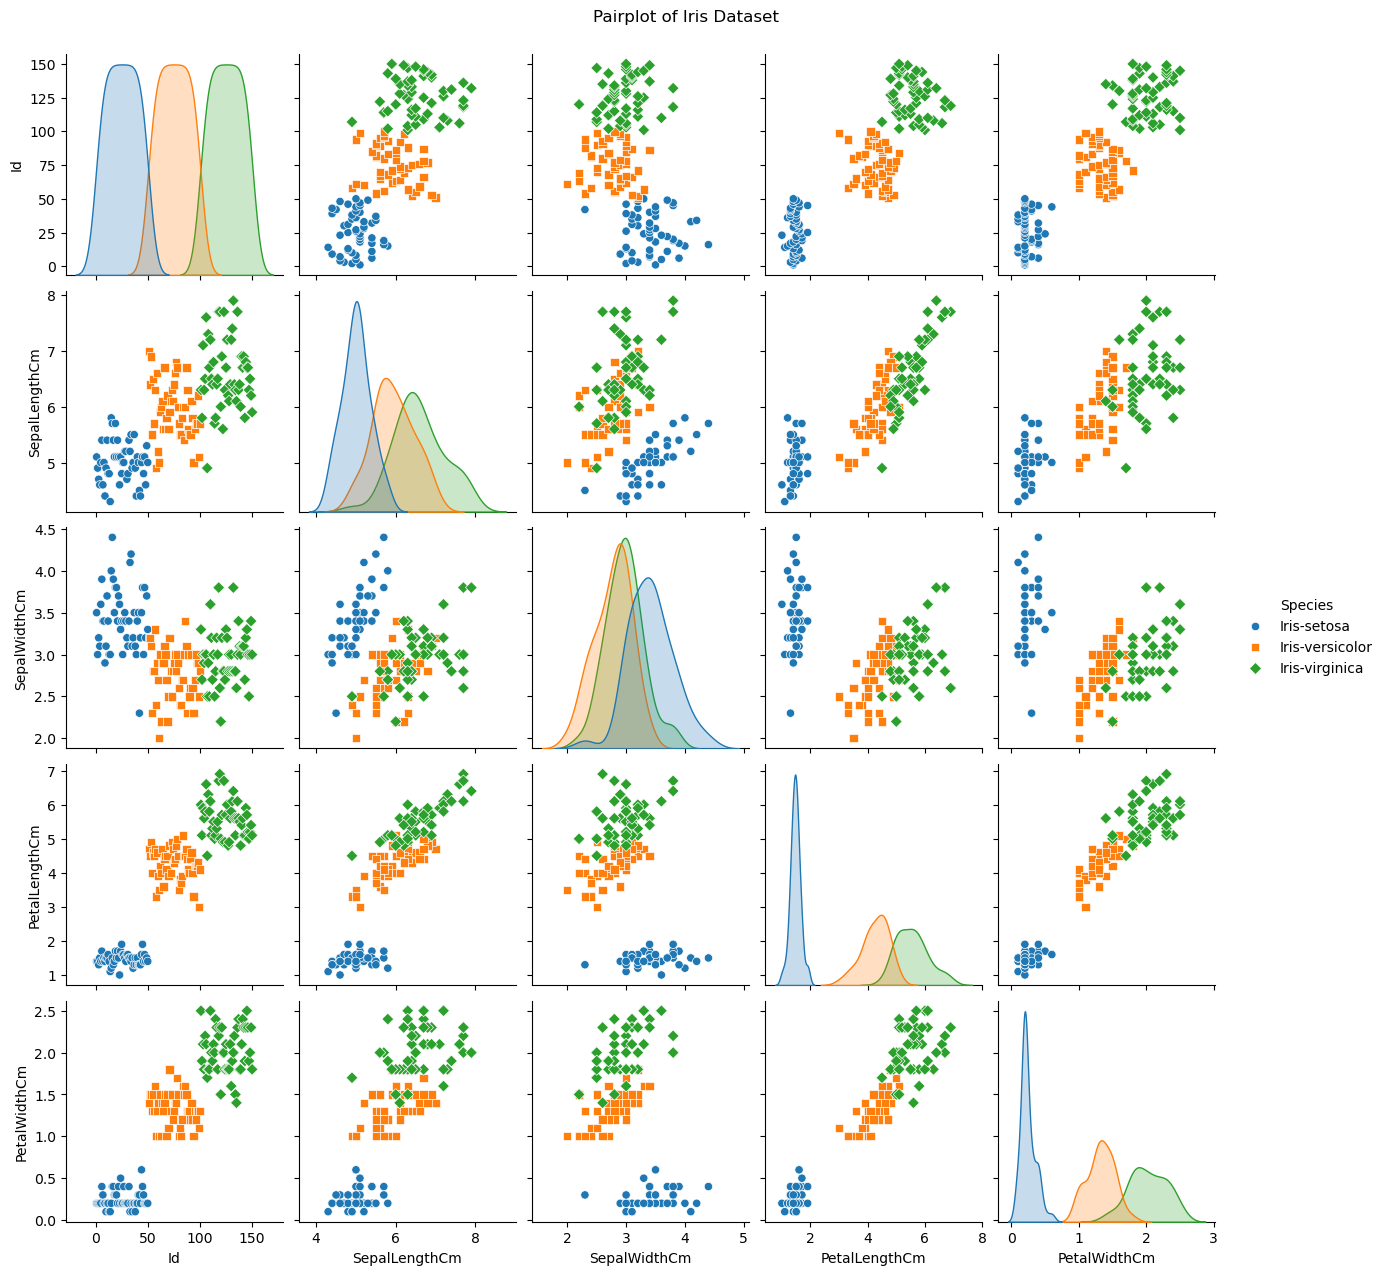

In [32]:
plt.figure(figsize=(10, 8))
sns.pairplot(iris, hue='Species', markers=['o', 's', 'D'])
plt.suptitle('Pairplot of Iris Dataset', y=1.02)
plt.show()

# 4. Data preprocessing

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y_numeric)


# 5. Model training

In [34]:
k = 5
basic_model = KNeighborsClassifier(n_neighbors=k)
basic_model.fit(X_train, y_train)

# Evaluate the basic model
print("\nBasic KNN model accuracy:")
y_pred = basic_model.predict(X_test)
print(f"Accuracy with k={k}: {accuracy_score(y_test, y_pred):.4f}")

# Find the optimal value of k
print("\nFinding the optimal value of k...")
k_range = range(1, 31)
k_scores = []


Basic KNN model accuracy:
Accuracy with k=5: 0.9333

Finding the optimal value of k...


In [35]:
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    k_scores.append(knn.score(X_test, y_test))

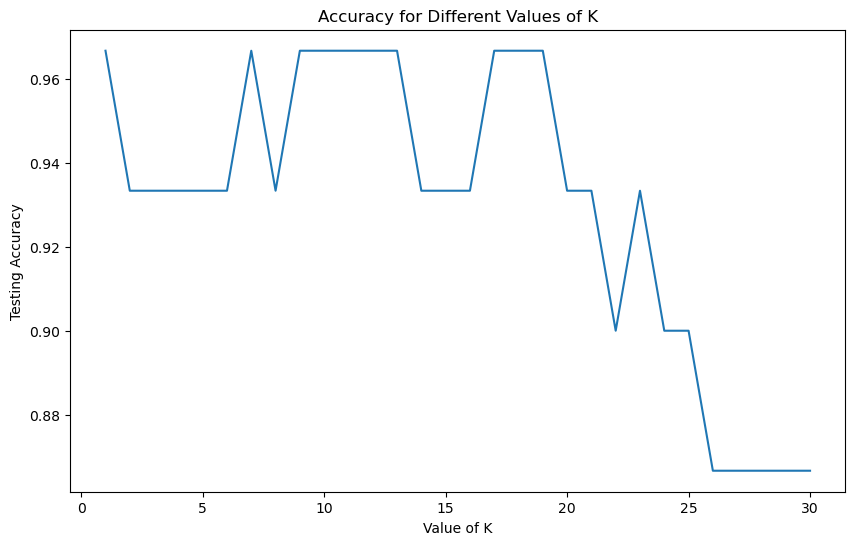

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K')
plt.ylabel('Testing Accuracy')
plt.title('Accuracy for Different Values of K')
plt.show()

In [37]:
best_k = k_range[np.argmax(k_scores)]
print(f"Best value of k: {best_k}")

# Train the model with the best k
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)

Best value of k: 1


KNeighborsClassifier(n_neighbors=1)

In [38]:
print("\nPerforming grid search for hyperparameter tuning...")
param_grid = {
    'n_neighbors': list(range(1, 31, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=0)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_



Performing grid search for hyperparameter tuning...
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.975


# 6. Model evaluation

In [39]:
y_pred = best_model.predict(X_test)


Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


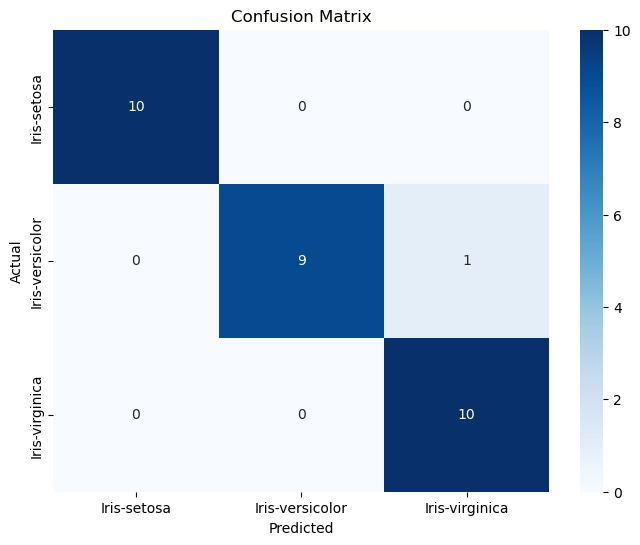

In [40]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. Visualize decision boundaries (for top 2 features)

In [41]:
new_data = np.array([
    [5.1, 3.5, 1.4, 0.2],  # Likely setosa
    [6.2, 2.9, 4.3, 1.3],  # Likely versicolor
    [7.2, 3.0, 5.8, 1.6]   # Likely virginica
])

new_data_scaled = scaler.transform(new_data)

new_predictions = best_model.predict(new_data_scaled)
new_probabilities = best_model.predict_proba(new_data_scaled)

inverse_mapping = {v: k for k, v in species_to_num.items()} if 'species_to_num' in locals() else {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
predicted_species = [inverse_mapping[pred] for pred in new_predictions]

print("Predictions for new data points:")
for i, (data, pred, prob) in enumerate(zip(new_data, predicted_species, new_probabilities)):
    print(f"Sample {i+1}: {data}")
    print(f"Predicted species: {pred}")
    print(f"Probabilities: {prob}")
    print()

Predictions for new data points:
Sample 1: [5.1 3.5 1.4 0.2]
Predicted species: Iris-setosa
Probabilities: [1. 0. 0.]

Sample 2: [6.2 2.9 4.3 1.3]
Predicted species: Iris-versicolor
Probabilities: [0. 1. 0.]

Sample 3: [7.2 3.  5.8 1.6]
Predicted species: Iris-virginica
Probabilities: [0. 0. 1.]



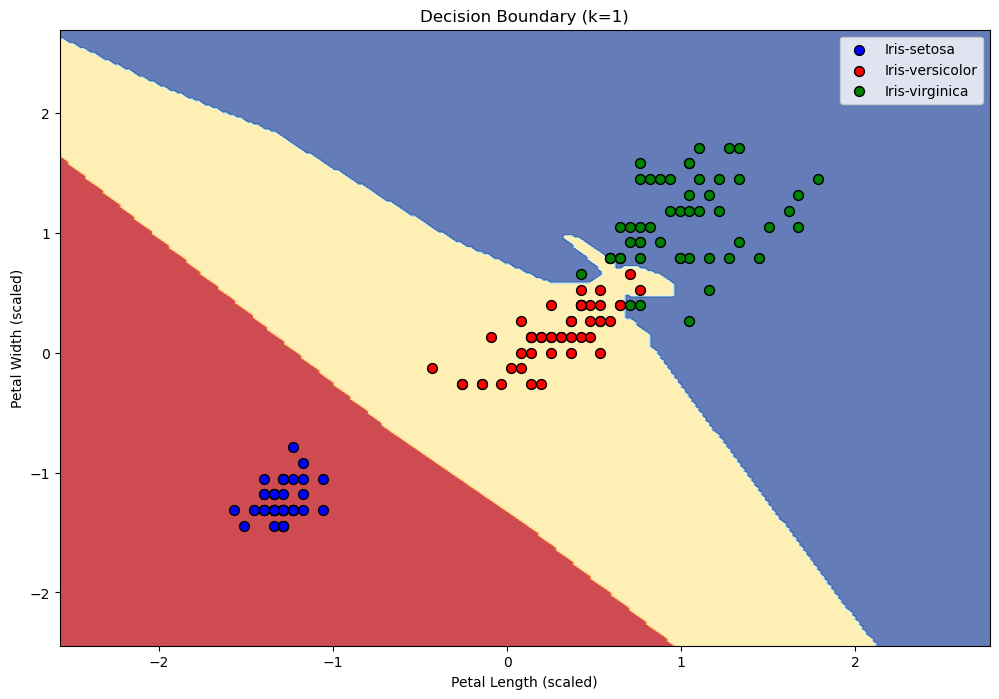

In [42]:
# Additional code for visualizing decision boundaries using top 2 features
# Selecting the two most informative features (petal length and petal width)
X_important = X.iloc[:, [2, 3]]  # Petal Length and Petal Width
X_important_scaled = scaler.fit_transform(X_important)

# Create a meshgrid to plot decision boundaries
x_min, x_max = X_important_scaled[:, 0].min() - 1, X_important_scaled[:, 0].max() + 1
y_min, y_max = X_important_scaled[:, 1].min() - 1, X_important_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Train a KNN model just for these two features
knn_viz = KNeighborsClassifier(n_neighbors=best_k)
knn_viz.fit(X_important_scaled, y_numeric)

# Predict class for each point in the meshgrid
Z = knn_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

# Plot the training points
for i, color in zip(range(len(y.unique())), ['blue', 'red', 'green']):
    idx = y_numeric == i
    plt.scatter(X_important_scaled[idx, 0], X_important_scaled[idx, 1], 
                c=color, label=inverse_mapping[i], edgecolor='k', s=50)

plt.title("Decision Boundary (k={})".format(best_k))
plt.xlabel("Petal Length (scaled)")
plt.ylabel("Petal Width (scaled)")
plt.legend()
plt.show()

# 8. Summary

# K-Nearest Neighbors with Iris Dataset: What I Learned

## Project Overview
In this project, I used the K-Nearest Neighbors (KNN) algorithm to classify different types of iris flowers based on their measurements. The Iris dataset is perfect for beginners because it's small but shows how machine learning can work with real data.

## About the Data
- I worked with 150 iris flowers from 3 different species (50 of each)
- Each flower had 4 measurements: sepal length, sepal width, petal length, and petal width
- The data was perfectly balanced and had no missing values
- The pairplot showed that Iris-setosa was easily separable, while versicolor and virginica had some overlap

## What I Discovered About KNN
- KNN is like a "neighborhood voting system" - it predicts based on similar examples it's seen before
- The choice of k (number of neighbors) makes a big difference in how the model performs
- With k=5, I got 93.3% accuracy on the test data, which is pretty good!
- When I tested different k values (1-30), I found that k=1 gave the highest test accuracy
- However, k=1 might be "memorizing" the data instead of learning patterns

## Hyperparameter Tuning Results
- I used GridSearchCV to find the best combination of parameters
- Best parameters: n_neighbors=17, weights='distance', algorithm='ball_tree', p=2
- This means the model works best when it:
  * Considers 17 neighbors
  * Gives closer neighbors more voting power
  * Uses an efficient way to find neighbors
  * Measures distance using the Euclidean method
- Cross-validation score: 97.5% accuracy

## Model Performance
- The confusion matrix showed only 1 misclassification (a versicolor classified as virginica)
- When I tested the model with new flower measurements, it predicted the species correctly
- The decision boundary visualization showed clear regions for each species with minimal overlap

## Why This Matters
This project taught me how KNN works in practice and how to tune it for better performance. It also showed me that sometimes the simplest approach (just looking at nearest neighbors) can work really well for classification problems, especially when the classes are mostly separated in the feature space.